### Il notebook implementa un classificatore addestrato sulle recensioni rappresentate come vettori. I vettori vengono estratti da un Word2Vec model addestrato from scratch sul nostro dataset. I vettori delle recensioni vengono calcolati come la media ponderata vec * tf-idf

In [1]:
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import statistics
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import re
import gensim
from gensim.models import KeyedVectors
import numpy as np
from collections import Counter
from numpy import dot
from numpy.linalg import norm
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases
from nltk import sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
import gensim.downloader as api
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from preprocessing import *

In [2]:
w2v_pretrained = Word2Vec.load("w2vPreTrained") # carica gli embedding pre trainati sul dataset test_set.csv. ciò ci serve esclusivamente per generare recensioni sintetiche

In [3]:
dataset = pd.read_csv("amazon_alexa.tsv", sep = "\t", encoding = "utf-8")
print(dataset.shape)
dataset.dropna(inplace = True)
print(dataset.shape)
dataset.drop(dataset[dataset.rating == 3].index, inplace=True)
print(dataset.shape)
dataset.drop_duplicates(subset = "verified_reviews", inplace = True)
print(dataset.shape)

(3150, 6)
(3150, 6)
(2998, 6)
(2196, 6)


In [4]:
# converte in un formato col quale lalvora imblearn
X = np.array(dataset["verified_reviews"].values).reshape(-1, 1)
y = list(dataset["feedback"].values)

In [34]:
#carichiamo il dataset e lo bilanciamo 
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# classe negativa = 50% della classe positiva
undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state = 0)

X, y = undersampler.fit_resample(X, y)


print('Resampled dataset shape %s' % Counter(y))

Resampled dataset shape Counter({1: 412, 0: 206})


In [6]:
X_temp = []

for rev in X:
  X_temp.append(rev[0])

In [7]:
new_text, new_sent_tok = tokenize_list_of_text(X_temp, custom_stopwords, False, 2)

total number of types extracted is: 1788


In [8]:
# Elimino token con freq minore di 2
cleaned_reviews = frequency_cleaning(new_sent_tok, 2)

In [9]:
#Estraggo i bigrammi
bigrams = Phrases(cleaned_reviews, scoring="npmi", threshold=0.60) #estrae le collocazioni tramite PMI
bigrams[cleaned_reviews][2]

['little', 'feature']

In [10]:
#Splittiamo train e test: saranno 329-165
X_train, X_test, Y_train, Y_test = train_test_split(bigrams[cleaned_reviews], y, test_size=0.20, random_state=10)

In [11]:
print('Train set is %s' % Counter(Y_train))

Train set is Counter({1: 329, 0: 165})


In [12]:
# genera recensioni sintetiche a partire dal train e usato solo nell'addestramento.
#prendo solo il train, non prendo ne recensioni artificiali, ne le prendo dal train, che sarebbe troppo facile.
#faccio zip di xtrain,ytrain e guardo se è negativa me la appendo alla lista delle negative
negative_reviews = []
for rev, label in zip(X_train, Y_train):
    if label == 0:
        negative_reviews.append(rev)

#
generated_reviews = generate_samples(negative_reviews, int(len(negative_reviews)/2), w2v_pretrained)

# run this only one time for extend. It shows some examples real vs artificial:
X_train.extend(generated_reviews)
Y_train.extend([0 for x in generated_reviews])

['joke']
-
['laugh']
--------------------------
['price', 'product', 'nice', 'quality', 'nice', 'feature', 'definitely', 'reason', 'give', 'think', 'may', 'buyer', 'error', 'first', 'ignore', 'product', 'plug', 'time', 'work', 'really', 'unlike', 'not_a', 'stand', 'device', 'also', 'speaker', 'not_very', 'loud', 'buy', 'bluetooth', 'speaker', 'sure', 'lot', 'figure', 'use', 'kind', 'seem', 'like', 'device', 'plus', 'set', 'awful', 'would', 'definitely', 'money', 'buy', 'one', 'actually']
-
['cost', 'product', 'decent', 'quality', 'decent', 'feature', 'definitely', 'reason', 'present', 'imagine', 'may', 'buyer', 'error', 'start', 'ignore', 'product', 'plug', 'sentence', 'run', 'truly', 'different', 'not_a', 'base', 'device', 'also', 'speaker', 'not_very', 'loudly', 'purchase', 'bluetooth', 'speaker', 'sure', 'plenty', 'figure', 'utilize', 'kind', 'seem', 'wish', 'device', 'plus', 'adjust', 'terrible', 'would', 'definitely', 'money', 'purchase', 'one', 'really']
-------------------------

['purchase', 'plus', 'build', 'come', 'free', 'hue', 'bulb', 'get', 'everything', 'set', 'realize', 'plus', 'forbid', 'full', 'functionality', 'bulb', 'turn', 'light', 'stay', 'color', 'still', 'hue', 'bridge', 'full', 'function', 'feature', 'bulb', 'wish', 'buy', 'bulb', 'bridge', 'use', 'already', 'since', 'build', 'useless', 'buy', 'hue', 'bridge', 'get', 'full', 'light']
-
['buy', 'plus', 'build', 'arrive', 'free', 'hue', 'lightbulb', 'receive', 'everything', 'adjust', 'see', 'plus', 'forbid', 'wide', 'functionality', 'lightbulb', 'play', 'lighting', 'stop', 'color', 'yet', 'hue', 'bridge', 'wide', 'purpose', 'feature', 'lightbulb', 'like', 'purchase', 'lightbulb', 'bridge', 'utilize', 'already', 'since', 'build', 'useless', 'purchase', 'hue', 'bridge', 'receive', 'wide', 'lighting']
--------------------------
['terrible', 'stop', 'work', 'one', 'day']
-
['awful', 'quit', 'run', 'one', 'day']
--------------------------
['old', 'keep', 'crash', 'use', 'buy', 'one', 'think', 'old', '

['device', 'show', 'seem', 'huge', 'potential', 'really', 'want', 'like', 'soon', 'find', 'quite', 'bit', 'disappointing', 'not_the', 'end', 'world', 'use', 'like', 'use', 'little', 'month', 'screen', 'start', 'screen', 'quick', 'look', 'make', 'understand', 'pointless', 'ask', 'replacement', 'people', 'device', 'replace', 'start', 'answer', 'quite', 'time', 'long', 'story', 'short', 'move', 'use', 'expensive', 'voice', 'activate', 'light', 'switch', 'hue', 'light', 'like']
-
['device', 'picture', 'seem', 'vast', 'potential', 'truly', 'need', 'wish', 'shortly', 'discover', 'quite', 'bit', 'disappointing', 'not_the', 'end', 'world', 'utilize', 'wish', 'utilize', 'small', 'month', 'screen', 'begin', 'screen', 'immediate', 'see', 'ready', 'interpret', 'pointless', 'demand', 'replacement', 'people', 'device', 'substitute', 'begin', 'response', 'quite', 'sentence', 'long', 'story', 'dead', 'movement', 'utilize', 'expensive', 'voice', 'trigger', 'lighting', 'change', 'hue', 'lighting', 'wish

In [13]:
print('Train set is %s' % Counter(Y_train))

Train set is Counter({1: 329, 0: 241})


In [38]:
#tfidf weighting sui token
# lambda: i:i evita tokenizzazione

tfidf = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, min_df = 0)
tfidf_model = tfidf.fit_transform(X_train) #
X_test_tf = tfidf.transform(X_test) #
review = 1
for score, feature in zip(tfidf_model.toarray()[review], tfidf.get_feature_names_out()):
    if score > 0.0:
        print(feature, score)

bass 0.43857828532933923
get 0.22024499174682433
great 0.2247690722731819
idle 0.29911950316887775
miss 0.36554410475419424
recognize 0.4556341840374841
sound 0.26570121995060786
still 0.2855958668417301
thing 0.24613904269023423
time 0.25529600517955614


In [15]:
tfidf.inverse_transform(tfidf_model)[0]

array(['purchase', 'new', 'like', 'look', 'box', 'original',
       'even_though', 'perfectly', 'work', 'far', 'week', 'two',
       'refurbish', 'happy'], dtype='<U15')

In [16]:
print(tfidf_model[0,:].data)
tfidf.inverse_transform(tfidf_model)[0]

[0.2030027  0.2146646  0.16414036 0.22487128 0.28412446 0.26694879
 0.27777188 0.29964046 0.14736372 0.21283613 0.27208931 0.2374712
 0.2295642  0.51587761]


array(['purchase', 'new', 'like', 'look', 'box', 'original',
       'even_though', 'perfectly', 'work', 'far', 'week', 'two',
       'refurbish', 'happy'], dtype='<U15')

### Word2Vec: 
rappresentazione vettoriale delle parole in modo che parole semanticamente simili siano rappresentate da vettori simili.
L'algoritmo word2vec utilizza una rete neurale artificiale per imparare le relazioni tra le parole e crea un modello che prevede la probabilità che una determinata parola appaia in una data finestra di contesto. I vettori di parole creati da word2vec sono noti come "word embeddings"

In [39]:
#add only train
#skipgram-cbow
#hierchicalsoftmax-negativesampling
w2v_model = Word2Vec(X_train, vector_size=100, window = 10, min_count = 0, sg=1, hs = 1, epochs= 100, seed = 5)

In [18]:
w2v_model.wv.most_similar("love", topn = 10)

[('great', 0.4427292048931122),
 ('use', 0.4180808961391449),
 ('cook', 0.4167807102203369),
 ('trailer', 0.38419869542121887),
 ('list', 0.3723585307598114),
 ('movie', 0.37192484736442566),
 ('find', 0.3699047267436981),
 ('want', 0.36399388313293457),
 ('favorite', 0.3593404293060303),
 ('live', 0.35832124948501587)]

In [19]:
w2v_model.wv.most_similar("love", topn = 2000)[-10:]

[('unplug', -0.06076349318027496),
 ('money', -0.06643775850534439),
 ('listen', -0.06783126294612885),
 ('phone', -0.07216164469718933),
 ('zigbee', -0.07591379433870316),
 ('useful', -0.07745841145515442),
 ('half', -0.07897010445594788),
 ('return', -0.08645745366811752),
 ('ignore', -0.11667902767658234),
 ('also', -0.13518528640270233)]

In [20]:
def review_vectors(tokens, size = 100, weights = []):

    """Genera un vettore per ogni recensione: questo vettore
    è calcolato come la media ponderata (t * w: token vettore myfts * peso tfidf) dei vettori dei token nella recensione.
    Il vettore risultante è normalizzato alla fine."""

    vec = np.zeros(size).reshape((1, size))
    count = 0

    import statistics

    # if len(tokens) != len(weights):
    #     print("nope")

    for word, weight in zip(tokens, weights):
        try:
            vec += w2v_model.wv[word] * weight #somm pond
            count +=1 #sommiamo a vec
        except KeyError:
            print("non trovo", word)
            continue

    if count!= 0:
        vec = vec / norm(vec) 
        
    return vec

In [21]:
#creazione vettore per ogni recensione nel train 

w2v_X_train = np.zeros((len(X_train), w2v_model.vector_size))
for i in range(len(X_train)):
    w2v_X_train[i,:] = review_vectors(tfidf.inverse_transform(tfidf_model[i, :])[0], w2v_model.vector_size, tfidf_model[i,:].data)
w2v_df = pd.DataFrame(w2v_X_train)
w2v_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.082683,-0.151384,-0.074864,0.037651,-0.066716,0.020628,-0.011856,-0.013399,0.176482,-0.062232,...,0.260981,-0.014668,-0.199746,0.059677,-0.167955,0.148126,0.021636,-0.011042,0.135225,-0.107625
1,-0.010347,0.124159,-0.066431,-0.006549,0.084815,0.066802,-0.015166,-0.080459,0.349125,0.013353,...,-0.020182,-0.003024,0.030451,0.011098,-0.092784,-0.092140,-0.167290,0.066240,0.080714,-0.131729
2,-0.081133,0.065063,0.020470,0.089003,0.026025,0.060736,-0.083863,-0.036441,0.224956,-0.214574,...,0.027686,-0.022007,-0.130763,0.073864,-0.040541,0.041402,-0.262502,-0.102487,-0.001430,-0.006950
3,-0.020947,-0.121957,0.086852,0.145406,-0.006548,0.070339,0.088396,-0.196170,0.179448,-0.215863,...,0.096574,-0.030186,-0.172965,-0.064311,0.070436,0.087530,0.010788,-0.023226,-0.024420,-0.023326
4,-0.007948,-0.134698,-0.004376,0.008096,0.054369,-0.095736,-0.063928,-0.149390,0.069077,-0.160213,...,-0.074355,-0.044783,-0.103684,0.085555,-0.113270,0.023193,-0.009795,-0.042300,0.032336,-0.023733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,0.092886,-0.049526,0.126560,0.222132,0.004570,0.009963,0.064991,-0.123555,0.256326,-0.092037,...,-0.023978,-0.111858,0.000663,0.030032,0.011269,0.137639,0.026717,0.129009,0.083214,0.049911
566,-0.033430,-0.122807,0.129224,0.215387,-0.024991,0.105416,0.078930,-0.059992,0.177580,-0.024562,...,-0.019837,-0.163467,-0.095012,-0.091858,-0.104963,-0.028798,-0.044007,0.096463,0.089490,0.086948
567,-0.062368,0.007354,-0.040946,0.074390,0.186154,-0.036132,0.062150,0.035436,0.211906,-0.113501,...,0.062830,-0.012916,0.028467,-0.000391,-0.112686,0.147133,-0.004725,-0.102680,0.070786,-0.056791
568,-0.167305,0.016464,-0.089212,0.076259,-0.068883,0.175772,-0.087274,-0.135189,0.215763,0.032052,...,0.051127,-0.065445,0.104959,0.203136,-0.040568,0.077459,0.030946,-0.037723,0.022651,-0.017791


In [22]:
# creazione vettore per ogni recensione nel test
X_test_vec = np.zeros((len(X_test), w2v_model.vector_size))
for i in range(len(X_test)):
    X_test_vec[i,:] = review_vectors(tfidf.inverse_transform(X_test_tf[i, :])[0], w2v_model.vector_size, X_test_tf[i,:].data)

X_test_vec[0]

array([-0.09799289, -0.05067216,  0.05146624,  0.11736971,  0.20772899,
       -0.04710028,  0.09646967, -0.00158495,  0.30691639, -0.02966568,
       -0.0238826 ,  0.11941998, -0.02537429,  0.12804612,  0.10175276,
       -0.10420152,  0.1088097 ,  0.08596526, -0.03563311, -0.0017555 ,
        0.02545422, -0.16633818, -0.07566929,  0.07501576,  0.11934976,
       -0.05620475, -0.02616673,  0.05950712, -0.11073302,  0.085148  ,
       -0.01173625,  0.01932429, -0.14097825, -0.00136308,  0.02483497,
        0.01263816, -0.02281064,  0.0288551 , -0.05497307,  0.02782062,
        0.11803268, -0.24067109,  0.04596454, -0.09351736, -0.11503747,
        0.0843383 ,  0.06048436,  0.27585617,  0.04220683,  0.05171622,
        0.01478733,  0.19195014, -0.16158716, -0.04896266,  0.10921747,
       -0.00560302,  0.05251869,  0.12759514, -0.01391664,  0.01021231,
       -0.00827104, -0.19851284,  0.02801869, -0.04720987,  0.19638433,
       -0.00651141, -0.03749737,  0.00572463, -0.12428483, -0.11

In [23]:
from imblearn.under_sampling import TomekLinks

undersampler_nn = TomekLinks(sampling_strategy="all") # use tomekLinks to remove ambiguous data through nearest neighbours


# Fit and transform the X and y data
X_train_resampled, y_train_resampled = undersampler_nn.fit_resample(w2v_X_train, Y_train)

print('Resampled dataset shape %s' % Counter(y_train_resampled))

Resampled dataset shape Counter({1: 319, 0: 231})


In [40]:
svm = SVC(max_iter=3000, class_weight = "balanced", C = 1, gamma = 1, kernel = "poly", probability=True)
svm_model = svm.fit(X_train_resampled, y_train_resampled)
predictions = svm_model.predict(X_test_vec)
print(metrics.classification_report(Y_test, predictions))
#recall+

              precision    recall  f1-score   support

           0       0.73      0.80      0.77        41
           1       0.90      0.86      0.88        83

    accuracy                           0.84       124
   macro avg       0.82      0.83      0.82       124
weighted avg       0.84      0.84      0.84       124



In [25]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
import matplotlib.pyplot as plt

In [26]:
# estrae le probabilità di ogni prediction, serve a plottare la roc-auc curve
y_test_pred_proba = svm_model.predict_proba(X_test_vec)

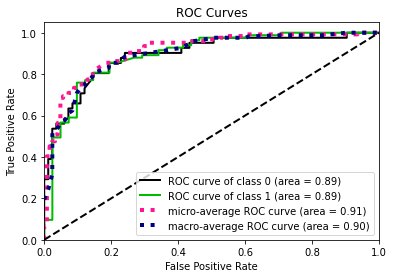

0.893329415221863


In [27]:
plot_roc(Y_test, svm_model.predict_proba(X_test_vec))
plt.show()
print(roc_auc_score(Y_test, y_test_pred_proba[:,1], average="macro"))

In [28]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [29]:
#Kernel, che determina la funzione usata per trasformare i dati in input in uno spazio ad alto numero di dimensioni;
#C, che controlla la quantità di penalizzazione assegnata ad ev errori di classif nel processo di add del modello;
#Gamma,  controlla l’influenza di ogni esempio del training;
#Class weight, parametro di regolazione che viene utilizzato per gestire le classi sbilanciate.

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf','linear', 'poly'],
              'class_weight':['balanced', None],
}

In [30]:
grid = GridSearchCV(SVC(), param_grid, refit = True, scoring = "f1", cv=kfold, verbose=3)
grid.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.864 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.938 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.828 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.883 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.889 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear;, score=0.882 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear;, score=0.937 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear;, score=0.806 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear;, score=0.902 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, gamma=1, kernel=lin

[CV 3/5] END C=0.1, class_weight=None, gamma=0.1, kernel=poly;, score=0.736 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, gamma=0.1, kernel=poly;, score=0.736 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, gamma=0.1, kernel=poly;, score=0.728 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, gamma=0.01, kernel=rbf;, score=0.736 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, gamma=0.01, kernel=rbf;, score=0.736 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, gamma=0.01, kernel=rbf;, score=0.736 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=None, gamma=0.01, kernel=rbf;, score=0.736 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=None, gamma=0.01, kernel=rbf;, score=0.728 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=None, gamma=0.01, kernel=linear;, score=0.874 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=None, gamma=0.01, kernel=linear;, score=0.899 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=None, gamma

[CV 5/5] END C=1, class_weight=balanced, gamma=0.001, kernel=poly;, score=0.728 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, gamma=1, kernel=rbf;, score=0.875 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, gamma=1, kernel=rbf;, score=0.908 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, gamma=1, kernel=rbf;, score=0.848 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, gamma=1, kernel=rbf;, score=0.922 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, gamma=1, kernel=rbf;, score=0.896 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, gamma=1, kernel=linear;, score=0.877 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, gamma=1, kernel=linear;, score=0.885 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, gamma=1, kernel=linear;, score=0.831 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, gamma=1, kernel=linear;, score=0.929 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, gamma=1, kernel=linear;, score=0.891 total

[CV 5/5] END C=10, class_weight=balanced, gamma=0.1, kernel=poly;, score=0.728 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.889 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.929 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.784 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.900 total time=   0.0s
[CV 5/5] END C=10, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.909 total time=   0.0s
[CV 1/5] END C=10, class_weight=balanced, gamma=0.01, kernel=linear;, score=0.836 total time=   0.0s
[CV 2/5] END C=10, class_weight=balanced, gamma=0.01, kernel=linear;, score=0.866 total time=   0.0s
[CV 3/5] END C=10, class_weight=balanced, gamma=0.01, kernel=linear;, score=0.846 total time=   0.0s
[CV 4/5] END C=10, class_weight=balanced, gamma=0.01, kernel=linear;, score=0.894 total time=   0.0s
[CV 5/5]

[CV 1/5] END C=100, class_weight=balanced, gamma=1, kernel=linear;, score=0.850 total time=   0.0s
[CV 2/5] END C=100, class_weight=balanced, gamma=1, kernel=linear;, score=0.843 total time=   0.0s
[CV 3/5] END C=100, class_weight=balanced, gamma=1, kernel=linear;, score=0.835 total time=   0.0s
[CV 4/5] END C=100, class_weight=balanced, gamma=1, kernel=linear;, score=0.889 total time=   0.0s
[CV 5/5] END C=100, class_weight=balanced, gamma=1, kernel=linear;, score=0.773 total time=   0.0s
[CV 1/5] END C=100, class_weight=balanced, gamma=1, kernel=poly;, score=0.894 total time=   0.0s
[CV 2/5] END C=100, class_weight=balanced, gamma=1, kernel=poly;, score=0.862 total time=   0.0s
[CV 3/5] END C=100, class_weight=balanced, gamma=1, kernel=poly;, score=0.878 total time=   0.0s
[CV 4/5] END C=100, class_weight=balanced, gamma=1, kernel=poly;, score=0.937 total time=   0.0s
[CV 5/5] END C=100, class_weight=balanced, gamma=1, kernel=poly;, score=0.861 total time=   0.0s
[CV 1/5] END C=100, 

[CV 1/5] END C=100, class_weight=None, gamma=0.01, kernel=linear;, score=0.866 total time=   0.0s
[CV 2/5] END C=100, class_weight=None, gamma=0.01, kernel=linear;, score=0.864 total time=   0.0s
[CV 3/5] END C=100, class_weight=None, gamma=0.01, kernel=linear;, score=0.806 total time=   0.0s
[CV 4/5] END C=100, class_weight=None, gamma=0.01, kernel=linear;, score=0.871 total time=   0.0s
[CV 5/5] END C=100, class_weight=None, gamma=0.01, kernel=linear;, score=0.785 total time=   0.0s
[CV 1/5] END C=100, class_weight=None, gamma=0.01, kernel=poly;, score=0.736 total time=   0.0s
[CV 2/5] END C=100, class_weight=None, gamma=0.01, kernel=poly;, score=0.736 total time=   0.0s
[CV 3/5] END C=100, class_weight=None, gamma=0.01, kernel=poly;, score=0.736 total time=   0.0s
[CV 4/5] END C=100, class_weight=None, gamma=0.01, kernel=poly;, score=0.736 total time=   0.0s
[CV 5/5] END C=100, class_weight=None, gamma=0.01, kernel=poly;, score=0.728 total time=   0.0s
[CV 1/5] END C=100, class_weig

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='f1', verbose=3)

In [31]:
print(grid.best_params_)

{'C': 1, 'class_weight': None, 'gamma': 1, 'kernel': 'poly'}


In [32]:
grid_predictions = grid.predict(X_test_vec)
print(classification_report(Y_test, grid_predictions)) 

              precision    recall  f1-score   support

           0       0.77      0.73      0.75        41
           1       0.87      0.89      0.88        83

    accuracy                           0.84       124
   macro avg       0.82      0.81      0.82       124
weighted avg       0.84      0.84      0.84       124



In [33]:
review = """To be fair i don't like this version, it's very loud and the sound quality is poor"""

review_tok = tokenize_list_of_text([review], custom_stopwords, False, 2)[1]
print(review_tok)
review_vec = review_vectors(review_tok[0], w2v_model.vector_size, [1 for x in range(len(review_tok[0]))])
pred = grid.predict(review_vec)
pred

total number of types extracted is: 7
[['fair', 'unlike', 'version', 'loud', 'sound', 'quality', 'poor']]
non trovo fair
non trovo version


array([0])